In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from causalimpact import CausalImpact

In [31]:
revenue = pd.read_csv('../data/revenue_loyal_customers.csv', index_col=0)
revenue['date'] = pd.to_datetime(revenue['date'])

In [32]:
revenue

,date,revenue
0,2021-06-28,5358695.20
1,2021-06-29,5377477.76
2,2021-06-30,5464551.08
3,2021-07-01,5891338.36
4,2021-07-02,6743656.05
...,...,...
275,2022-03-30,5679899.28
276,2022-03-31,5888872.90
277,2022-04-01,7470889.75
278,2022-04-02,6985402.32


In [33]:
# check if 'date' column is a datetime column
if revenue['date'].dtype == 'datetime64[ns]':
    print("The 'date' column is a datetime column")
else:
    print("The 'date' column is not a datetime column")

The 'date' column is a datetime column


### S&P index | Does not have data of closing value during weekend so have to add them

In [25]:
sp = pd.read_csv('../data/Download Data - INDEX_US_S&P US_SPX.csv')
sp = sp[['Date', 'Close']]
sp = sp.rename(columns={'Date': 'date', 'Close': 'close'})
sp['close'] = sp['close'].str.replace(',', '').astype(float)
sp.sort_values(by='date', inplace=True)
sp['date'] = pd.to_datetime(sp['date'], format='%m/%d/%Y')
sp['date'].dt.strftime('%Y-%m-%d')
sp.sort_values(by='date')
sp.set_index('date', inplace=True)

In [17]:
all_days = pd.date_range(min(revenue['date']), max(revenue['date']), freq='D')
all_days_df = pd.DataFrame(index=all_days)
all_days_df.index = pd.to_datetime(all_days_df.index)

In [27]:
sp_full = pd.merge(all_days_df, sp, how='outer', left_index=True, right_index=True)
sp_full.fillna(method='ffill', inplace=True)

In [28]:
sp_full

,close
2021-06-28,4290.61
2021-06-29,4291.80
2021-06-30,4297.50
2021-07-01,4319.94
2021-07-02,4352.34
...,...
2022-03-30,4602.45
2022-03-31,4530.41
2022-04-01,4545.86
2022-04-02,4545.86


### Merge new found tracker with the y predictor

In [34]:
ts_data = pd.merge(revenue, sp_full, how='outer', left_on='date', right_index=True)

In [35]:
ts_data

,date,revenue,close
0,2021-06-28,5358695.20,4290.61
1,2021-06-29,5377477.76,4291.80
2,2021-06-30,5464551.08,4297.50
3,2021-07-01,5891338.36,4319.94
4,2021-07-02,6743656.05,4352.34
...,...,...,...
275,2022-03-30,5679899.28,4602.45
276,2022-03-31,5888872.90,4530.41
277,2022-04-01,7470889.75,4545.86
278,2022-04-02,6985402.32,4545.86


### Define periods

In [36]:
ts_pre_period = [pd.to_datetime(date) for date in ['2021-06-28', '2021-11-14']]
ts_post_period = [pd.to_datetime(date) for date in ['2021-11-15', '2022-04-03']]
ts_pre_period = [date.strftime('%Y-%m-%d') for date in ts_pre_period]
ts_post_period = [date.strftime('%Y-%m-%d') for date in ts_post_period]

### Run CI

In [39]:
ts_impact = CausalImpact(ts_data, ts_pre_period, ts_post_period)
ts_impact.run()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43123D+00    |proj g|=  2.10817D-01

At iterate    5    f=  1.33347D+00    |proj g|=  2.96279D-02

At iterate   10    f=  1.33242D+00    |proj g|=  2.89349D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   4.616D-06   1.332D+00
  F =   1.3324203716942999     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


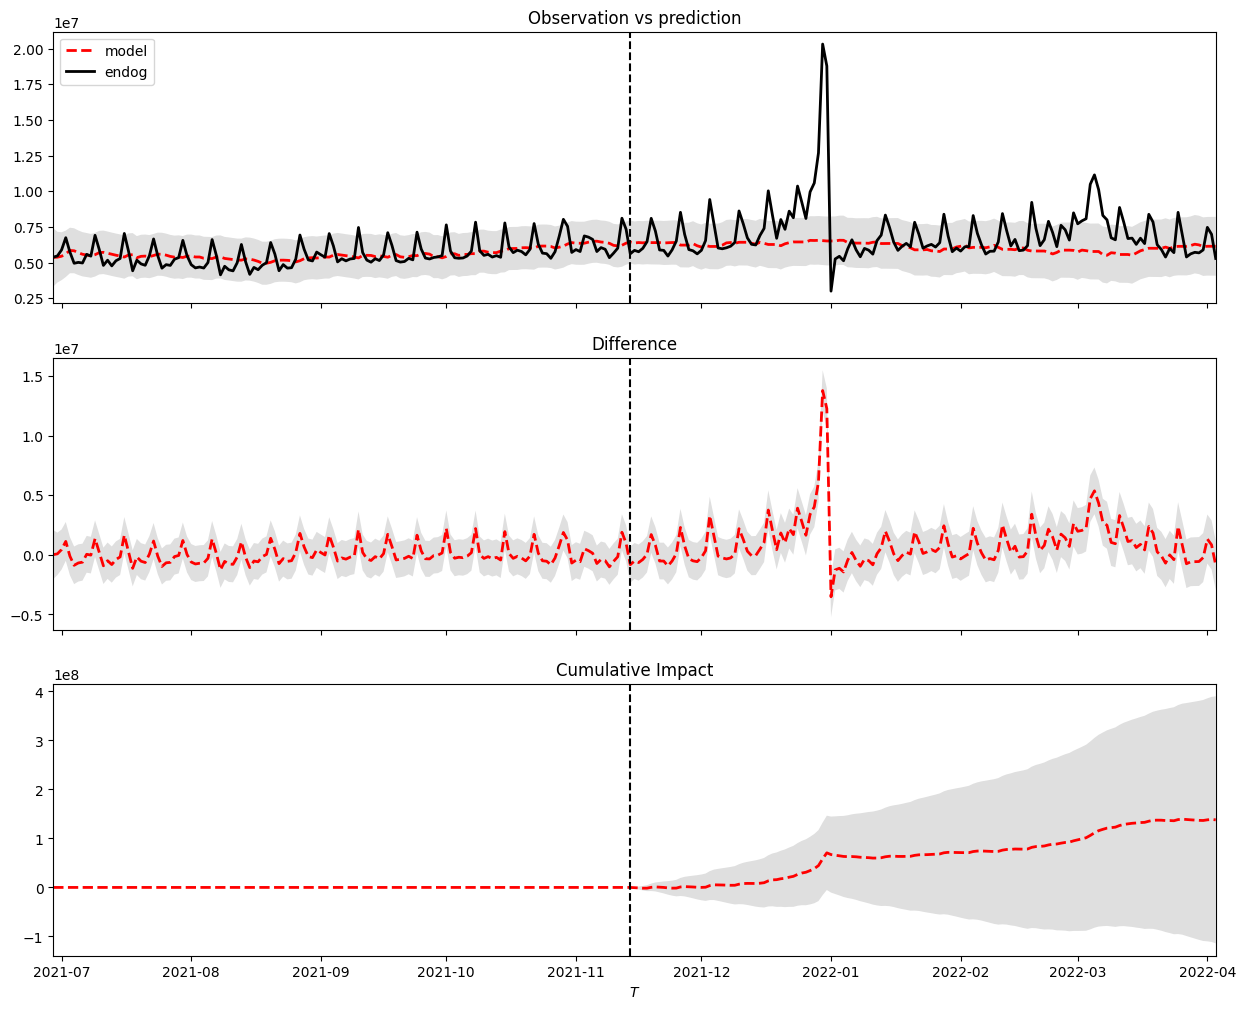

In [40]:
ts_impact.plot()

### Add Albert Heijn searches | Why? Because it is an external variable known related to the outcome variable but unrelated to the treatment. In order to combat the Christmas peak. Moreover, searches are per week thus have to set the daily searches to the week average ourselves

In [44]:
ah = pd.read_csv('../data/multiTimeline(2).csv')
ah = ah.iloc[1:]
ah.rename(columns={'Categorie: Alle categorieën': 'searches'}, inplace=True)
ah.index = pd.to_datetime(ah.index)
ah['searches'] = ah['searches'].astype(int)
ah.sort_index()

,searches
2021-07-04,45
2021-07-11,46
2021-07-18,47
2021-07-25,47
2021-08-01,46
2021-08-08,50
2021-08-15,49
2021-08-22,46
2021-08-29,45
2021-09-05,45


In [45]:
ah_full = pd.merge(all_days_df, ah, how='outer', left_index=True, right_index=True)
ah_full['searches'].fillna(method='ffill', limit=6, inplace=True)
ah_full['searches'].iloc[:7] = 45.0

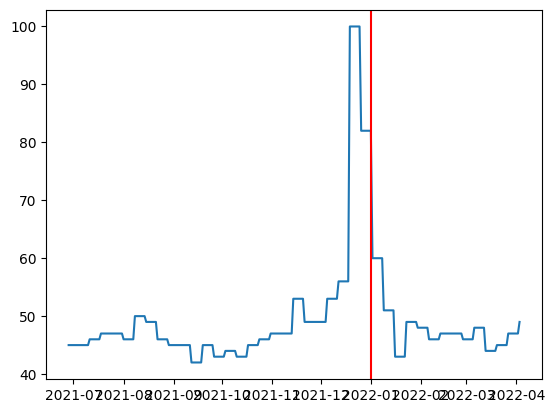

In [53]:
# create line chart of AH searches
plt.plot(ah_full.index,  ah_full['searches'])
plt.axvline(x=pd.to_datetime('2022-01-01'), color='red')
plt.show()

In [47]:
ts_data2 = pd.merge(ts_data, ah_full, how='outer', left_on='date', right_index=True)

In [48]:
ts_data2

,date,revenue,close,searches
0,2021-06-28,5358695.20,4290.61,45.0
1,2021-06-29,5377477.76,4291.80,45.0
2,2021-06-30,5464551.08,4297.50,45.0
3,2021-07-01,5891338.36,4319.94,45.0
4,2021-07-02,6743656.05,4352.34,45.0
...,...,...,...,...
275,2022-03-30,5679899.28,4602.45,47.0
276,2022-03-31,5888872.90,4530.41,47.0
277,2022-04-01,7470889.75,4545.86,47.0
278,2022-04-02,6985402.32,4545.86,47.0


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42733D+00    |proj g|=  2.12239D-01

At iterate    5    f=  1.31846D+00    |proj g|=  1.09291D-01

At iterate   10    f=  1.31273D+00    |proj g|=  2.19506D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   4.824D-07   1.313D+00
  F =   1.3127260301301058     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


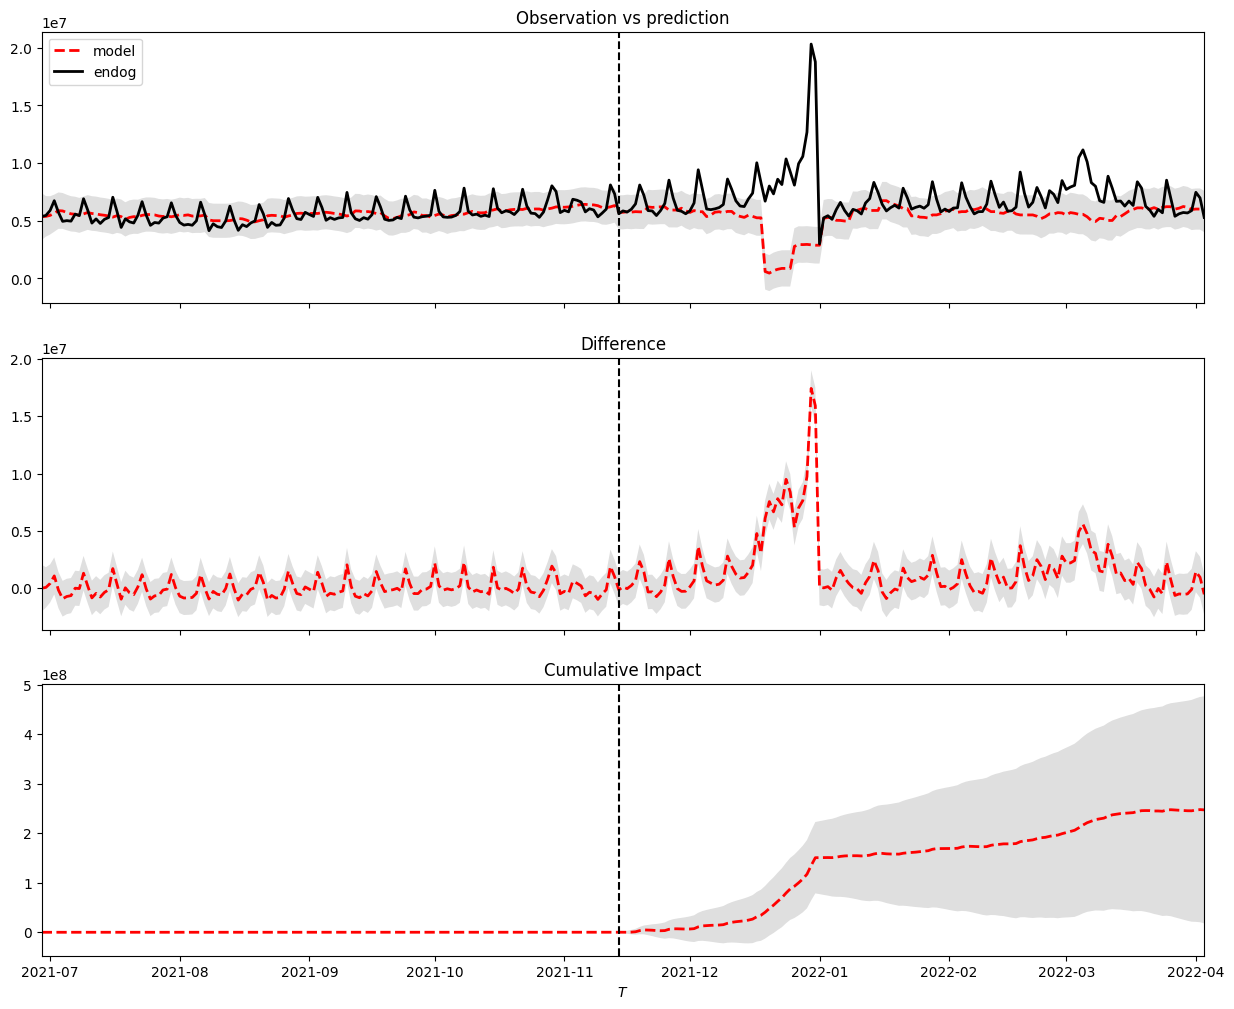

In [51]:
ts_impact = CausalImpact(ts_data2, ts_pre_period, ts_post_period)
ts_impact.run()
ts_impact.plot()

In [50]:
ts_impact.summary()

                                   Average               Cumulative
Actual                             7112852                995799350
Predicted                          6127247                857814634
95% CI                  [4325884, 7928610]  [605623851, 1110005416]
                                                                   
Absolute Effect                     985605                137984716
95% CI                  [2786967, -815757]  [390175498, -114206066]
                                                                   
Relative Effect                      16.1%                    16.1%
95% CI                     [45.5%, -13.3%]          [45.5%, -13.3%]
                                                                   
P-value                               0.0%                         
Prob. of Causal Effect              100.0%                         


In [60]:
revenue_12 = pd.read_csv('../data/revenue_customers_period_12.csv', index_col=0)
revenue_12['date'] = pd.to_datetime(revenue_12['date'])

In [61]:
revenue_12.set_index('date', inplace=True)
revenue_12

,revenue
date,
2021-06-28,13593107.92
2021-06-29,14985728.96
2021-06-30,16052418.08
2021-07-01,14063852.02
2021-07-02,16615768.90
...,...
2022-03-30,14666395.31
2022-03-31,14626520.46
2022-04-01,20102984.44


In [62]:
ts_data3 = pd.merge(ts_data2, revenue_12, how='outer', left_on='date', right_index=True)

In [63]:
ts_data3

,date,revenue_x,close,searches,revenue_y
0,2021-06-28,5358695.20,4290.61,45.0,13593107.92
1,2021-06-29,5377477.76,4291.80,45.0,14985728.96
2,2021-06-30,5464551.08,4297.50,45.0,16052418.08
3,2021-07-01,5891338.36,4319.94,45.0,14063852.02
4,2021-07-02,6743656.05,4352.34,45.0,16615768.90
...,...,...,...,...,...
275,2022-03-30,5679899.28,4602.45,47.0,14666395.31
276,2022-03-31,5888872.90,4530.41,47.0,14626520.46
277,2022-04-01,7470889.75,4545.86,47.0,20102984.44
278,2022-04-02,6985402.32,4545.86,47.0,18396983.28


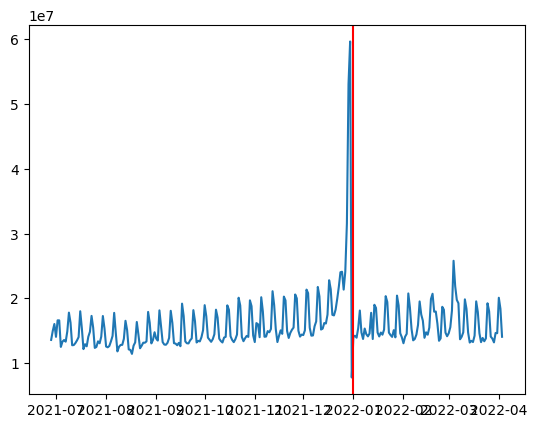

In [67]:
# create line chart of AH searches
plt.plot(revenue_12.index,  revenue_12['revenue'])
plt.axvline(x=pd.to_datetime('2022-01-01'), color='red')
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28599D-01    |proj g|=  5.76303D-01

At iterate    5    f=  6.70305D-01    |proj g|=  3.80369D-01

At iterate   10    f=  6.33035D-01    |proj g|=  1.97719D-01

At iterate   15    f=  6.30534D-01    |proj g|=  4.60229D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     26      1     0     0   1.173D-05   6.305D-01
  F =  0.63053394170886923     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


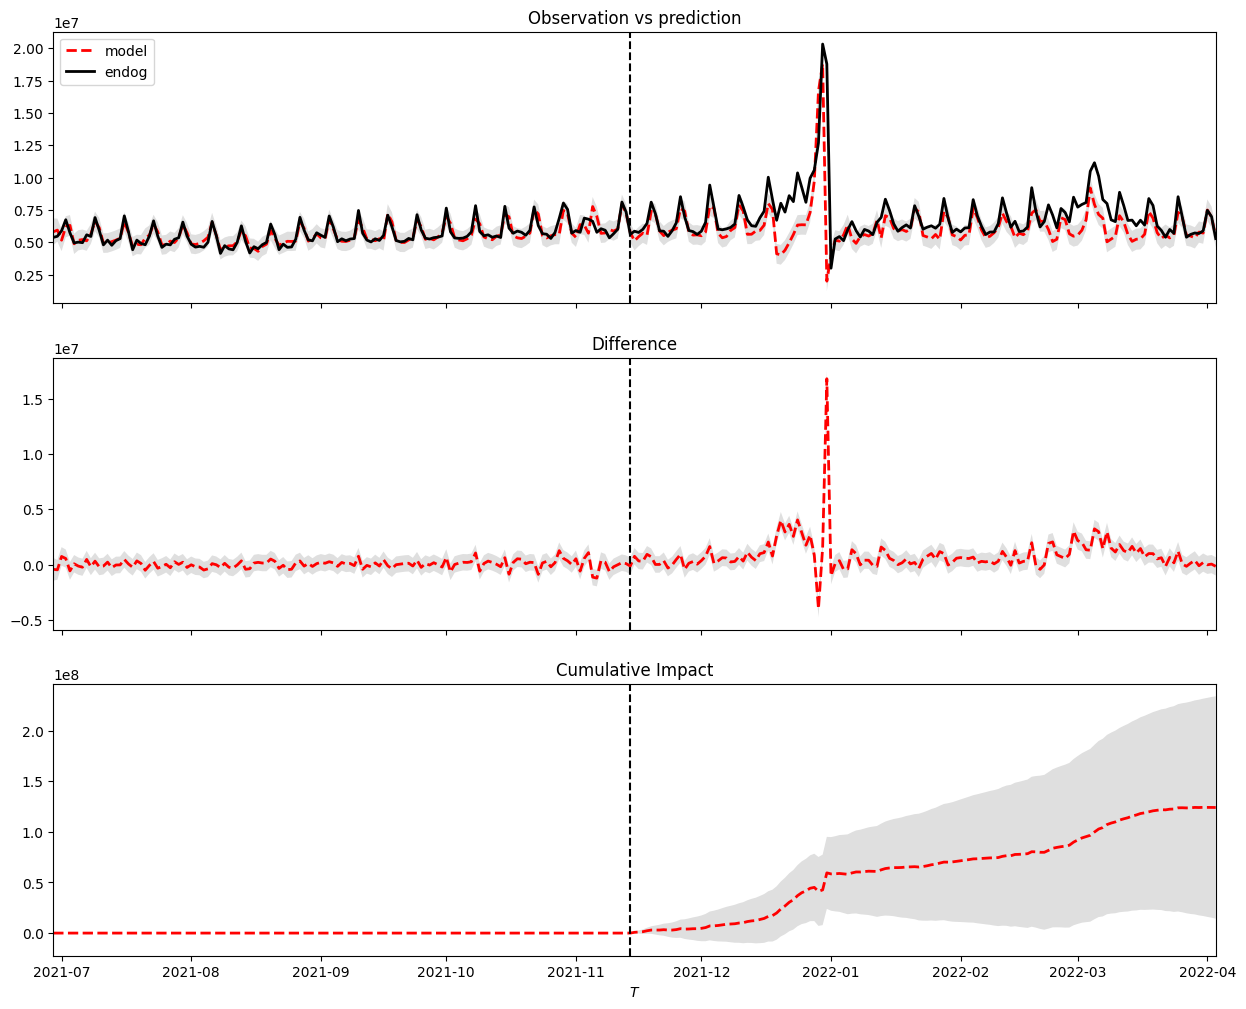

In [74]:
ts_impact = CausalImpact(ts_data3, ts_pre_period, ts_post_period)
ts_impact.run()
ts_impact.plot()

In [75]:
ts_impact.summary()

                                   Average              Cumulative
Actual                             7112852               995799350
Predicted                          6226608               871725230
95% CI                  [5442023, 7011194]  [761883234, 981567227]
                                                                  
Absolute Effect                     886243               124074119
95% CI                   [1670829, 101658]   [233916115, 14232123]
                                                                  
Relative Effect                      14.2%                   14.2%
95% CI                       [26.8%, 1.6%]           [26.8%, 1.6%]
                                                                  
P-value                               0.0%                        
Prob. of Causal Effect              100.0%                        
